<h1>Sparse Convolutional Denoising Autoencoders for Genotype Imputation <span class="tocSkip"></span></h1>

### ORIGINAL CODE FROM https://github.com/work-hard-play-harder/SCDA.

### Se trata de una modificación en la que los datos de entrada están reducidos. Esto se hace así dado que se han implementado otros enfoques como los basados en árboles con una gestión peor de las cantidades grandes de datos, sobre todo con una capacidad de pricesamiento limitada. Así, se prueba el modelo también con datos más reducidos para ver su comportanmiento.

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Dataset

## Loading data

In [2]:
df_test = pd.read_parquet('../../data/processed/df_test_reduced.parquet')

In [3]:
df_test.head()

,10335183_chrXV_303214_G_T,10341838_chrXV_309869_T_C,10341923_chrXV_309954_G_A,10342190_chrXV_310221_T_C,10342543_chrXV_310574_A_G,10344120_chrXV_312151_C_T,10346156_chrXV_314187_C_G,10349298_chrXV_317329_C_T,3141305_chrV_249350_C_T,10383039_chrXV_351070_C_T,...,10640336_chrXV_608367_C_T,1428699_chrIV_68677_T_C,1428933_chrIV_68911_A_C,6970183_chrXI_391971_C_T,6970060_chrXI_391848_C_T,6969970_chrXI_391758_T_A,3698349_chrVI_229520_A_G,6969924_chrXI_391712_C_T,5535875_chrIX_143302_C_T,7948843_chrXII_703815_C_T
0,1,1,1,1,1,1,1,1,1,2,...,2,1,1,1,1,1,2,1,1,1
1,1,1,1,1,1,1,1,1,2,1,...,1,2,2,2,2,2,1,2,1,2
2,2,2,2,2,2,2,2,2,1,2,...,2,1,1,1,1,1,1,1,2,1
3,2,2,2,2,2,2,2,2,2,1,...,1,2,2,2,2,2,2,2,2,2
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,2,2,2,2,2,1,1


## Preprocessing

In [4]:
# one hot encode
test_X = to_categorical(df_test)
test_X.shape

(877, 1000, 3)

# Method

## Load model

In [5]:
# returns a compiled model
SCDA = load_model('../../models/SDCA_reduced/SCDA_yeast.keras')

## Prediction on test data

In [6]:

# Porcentajes de pérdida
missing_perc_list = [0.1, 0.2, 0.3, 0.4]

# Función para calcular la probabilidad de los genotipos 0, 1, 2
def cal_prob(predict_missing_onehot):
    predict_prob = predict_missing_onehot[:,:,1:3] / predict_missing_onehot[:,:,1:3].sum(axis=2, keepdims=True)
    return predict_prob

# Diccionario para almacenar los resultados de precisión por cada porcentaje
accuracy_summary = {}

# Iterar sobre los porcentajes de datos faltantes
for missing_perc in missing_perc_list:
    avg_accuracy = []
    
    # Generar índices faltantes de una vez para todas las muestras
    num_samples = test_X.shape[0]
    missing_indices = [np.random.randint(test_X.shape[1], size=int(missing_perc * test_X.shape[1])) for _ in range(num_samples)]
    
    # Generar la matriz con datos faltantes en un solo paso
    test_X_missing = test_X.copy()
    for i in range(num_samples):
        test_X_missing[i, missing_indices[i], :] = [1, 0, 0]  # Generar genotipos faltantes
    
    # Predecir utilizando el modelo entrenado en lotes en lugar de predicciones individuales
    predict_onehot = SCDA.predict(test_X_missing, batch_size=32)  # Ajustar el tamaño del batch si es necesario
    
    # Iterar sobre cada muestra para calcular las precisiones
    for i in range(num_samples):
        # Solo se consideran las posiciones faltantes
        predict_missing_onehot = predict_onehot[i:i + 1, missing_indices[i], :]
        
        # Predicción de la etiqueta
        predict_missing = np.argmax(predict_missing_onehot, axis=2)

        # Etiqueta real
        label_missing_onehot = test_X[i:i + 1, missing_indices[i], :]
        label_missing = np.argmax(label_missing_onehot, axis=2)

        # Calcular la precisión
        correct_prediction = np.equal(predict_missing, label_missing)
        accuracy = np.mean(correct_prediction)
        avg_accuracy.append(accuracy)

    # Guardar la precisión promedio para el porcentaje actual
    accuracy_summary[missing_perc] = np.mean(avg_accuracy) 


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [7]:

# Mostrar el resumen de las precisiones promedio
print("\n=== Resumen de precisión promedio por porcentaje de pérdida ===")
for perc, acc in accuracy_summary.items():
    print(f'Porcentaje de pérdida: {perc * 100}%, Precisión promedio: {acc:.4f}')


=== Resumen de precisión promedio por porcentaje de pérdida ===
Porcentaje de pérdida: 10.0%, Precisión promedio: 0.8407
Porcentaje de pérdida: 20.0%, Precisión promedio: 0.8374
Porcentaje de pérdida: 30.0%, Precisión promedio: 0.8336
Porcentaje de pérdida: 40.0%, Precisión promedio: 0.8286


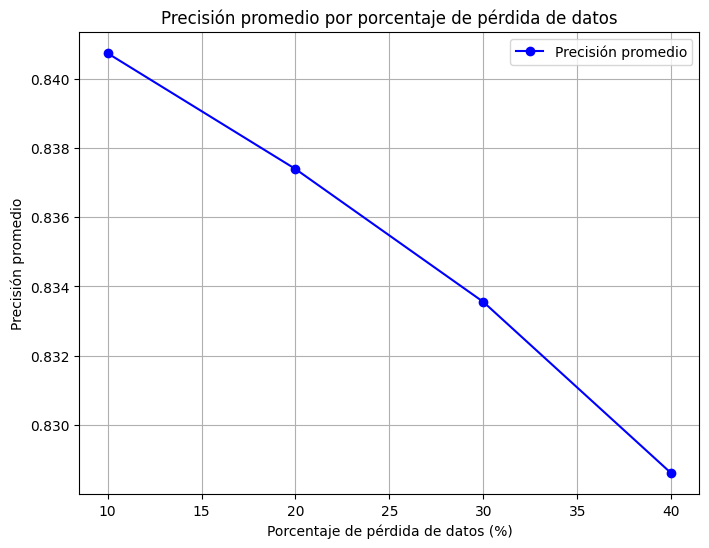

In [10]:
#Se añade un plotting al modelo original
# Extraer los porcentajes y las precisiones promedio del diccionario accuracy_summary
percentages = [perc * 100 for perc in accuracy_summary.keys()]
accuracies = [acc for acc in accuracy_summary.values()]

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.plot(percentages, accuracies, marker='o', linestyle='-', color='b', label='Precisión promedio')

# Personalizar el gráfico
plt.title('Precisión promedio por porcentaje de pérdida de datos')
plt.xlabel('Porcentaje de pérdida de datos (%)')
plt.ylabel('Precisión promedio')
plt.grid(True)
plt.legend()

# Mostrar el gráfico
plt.show()